In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from skrebate import ReliefF
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from skrebate import ReliefF
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score

# VC pour créer des données FOG et enlever des données NOFOG avec SMOTE et Random (condition ON et OFF par patient)

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from numpy import mean

def apply_resampling_pipeline(filepath, smote_strategy, under_strategy):
    print(f"Traitement du fichier {filepath}...")
    try:
        data = pd.read_csv(filepath)
        data_filtered = data.dropna(axis=1)
        data_filtered = data_filtered[data_filtered['label'] != 'transitionNoFog']
        X = data_filtered.drop('label', axis=1)
        y = data_filtered['label'].apply(lambda x: 1 if x in ['fog', 'transitionFog'] else 0)

        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

        # Check class balance in the training set
        class_ratio = y_train.value_counts(normalize=True)
        minor_class_ratio = class_ratio.min()

        if minor_class_ratio >= 0.5:
            print(f"No resampling needed for {filepath}, because class ratio > 0.5")
            return {'File': filepath, 'SMOTE Strategy': 'None', 'Under Strategy': 'None', 'ROC AUC Score': 'N/A', 'Note': 'No resampling due to class ratio > 0.5'}
        else:
            # Setup resampling and model
            smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
            under_sampler = RandomUnderSampler(sampling_strategy=under_strategy, random_state=42)
            model = DecisionTreeClassifier(random_state=42)
            steps = [('smote', smote), ('under_sampler', under_sampler), ('model', model)]
            pipeline = Pipeline(steps)

            # Evaluate pipeline
            cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
            scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
            mean_score = mean(scores)
            return {'File': filepath, 'SMOTE Strategy': smote_strategy, 'Under Strategy': under_strategy, 'ROC AUC Score': mean_score, 'Note': 'Resampling applied'}

    except Exception as e:
        print(f"Error processing {filepath}: {str(e)}")
        return None

# Path to directory
directory_path = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/'

# Stratégies de resampling à tester
smote_strategies = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1]
under_strategies = [0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7,0.8,0.9,1]

# DataFrame to store results
results_df = pd.DataFrame()

# Process each file with each combination of resampling strategies
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory_path, filename)
        for smote_strategy in smote_strategies:
            for under_strategy in under_strategies:
                result = apply_resampling_pipeline(filepath, smote_strategy, under_strategy)
                results_df = results_df.append(result, ignore_index=True)
                print(f"Added results for {filename} with SMOTE {smote_strategy} and UNDER {under_strategy} to the DataFrame.")

# Filter out the rows where ROC AUC Score is 'N/A'
valid_results = results_df[results_df['ROC AUC Score'] != 'N/A']

# Find the best combination based on ROC AUC Score
if not valid_results.empty:
    best_combination = valid_results.loc[valid_results['ROC AUC Score'].idxmax()]
    print(f"The best resampling combination is SMOTE {best_combination['SMOTE Strategy']} and UNDER {best_combination['Under Strategy']} with an ROC AUC Score of {best_combination['ROC AUC Score']}")

# Save results
results_file = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/resultats_resampling/results_combinations_with_shuffle.csv'
results_df.to_csv(results_file, index=False)
print(f"Results saved to {results_file}.")


# Sauvegarde des meilleurs paramètres de resampling pour chaque fichier

In [ ]:
# Grouper les résultats par fichier et trouver la combinaison avec le meilleur ROC AUC Score pour chaque fichier
best_combinations = results_df.loc[results_df.groupby('File')['ROC AUC Score'].idxmax()]

# Chemin du fichier où vous souhaitez sauvegarder les meilleures combinaisons
results_best_combinations_path = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/resultats_resampling/best_combinations_sampling_shuffle.csv'

# Utiliser la méthode to_csv sur l'objet DataFrame pour enregistrer les données dans un fichier CSV
best_combinations.to_csv(results_best_combinations_path, index=False)

print("Les meilleures combinaisons ont été sauvegardées avec succès.")

# Application individuelle des bons resampling sur chaque fichier

## 1. Observation des distributions des fichiers

In [31]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE


def apply_resampling_pipeline(filepath):
    data = pd.read_csv(filepath)
    data_filtered = data.dropna(axis=1)
    data_filtered = data_filtered[data_filtered['label'] != 'transitionNoFog']
    X = data_filtered.drop('label', axis=1)
    y = data_filtered['label'].apply(lambda x: 1 if x in ['fog', 'transitionFog'] else 0)
    
    
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)  
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)
    # Afficher la distribution avant le resampling
    print("Distribution before resampling:")
    print(y_train.value_counts())
    # Déterminer le ratio de sous-échantillonnage
    #     # Configure the resampling pipeline
    print("Applying resampling pipeline...")
    final_pipeline = Pipeline([
        ('smote', BorderlineSMOTE(sampling_strategy=0.9, random_state=42)),
        ('under_sampler', RandomUnderSampler(sampling_strategy=1, random_state=42))
    ])

    # Appliquer RandomUnderSampler à vos données
    X_resampled, y_resampled = final_pipeline.fit_resample(X_train, y_train)
        # Afficher la distribution après le resampling
        
    print("Distribution after resampling:")
    print(y_resampled.value_counts())
    
    print("Finished processing:", filepath)
    return X_resampled.reset_index(drop=True), y_resampled.reset_index(drop=True), X_test.reset_index(drop=True), y_test.reset_index(drop=True)

# Example usage
file_path = "C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/R_J_1961-10-0802RJ_ON_ON_all_extraction_features.csv"
X_train, y_train, X_test, y_test = apply_resampling_pipeline(file_path)





Distribution before resampling:
1    502
0    400
Name: label, dtype: int64
Applying resampling pipeline...
Distribution after resampling:
0    451
1    451
Name: label, dtype: int64
Finished processing: C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/R_J_1961-10-0802RJ_ON_ON_all_extraction_features.csv


## 2. Applications des resamplings pour chaque fichier

In [39]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Chemin vers le DataFrame des meilleures combinaisons
best_combinations_path = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/resultats_resampling/best_combinations_results.csv'
best_combinations_df = pd.read_csv(best_combinations_path)

# Fonction pour appliquer le resampling et sauvegarder les résultats
def process_and_save(filepath, smote_strategy, under_strategy):
    print(f"Traitement du fichier : {filepath}")
    
    data = pd.read_csv(filepath)
    data_filtered = data.dropna(axis=1)
    data_filtered = data_filtered[data_filtered['label'] != 'transitionNoFog']
    X = data_filtered.drop('label', axis=1)
    y = data_filtered['label'].apply(lambda x: 1 if x in ['fog', 'transitionFog'] else 0)

    print("Préparation des données...")
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

    print(f"Application du resampling: SMOTE={smote_strategy}, Under={under_strategy}")
    smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
    under_sampler = RandomUnderSampler(sampling_strategy=under_strategy, random_state=42)
    pipeline = Pipeline([
        ('smote', smote),
        ('under_sampler', under_sampler)
    ])

    X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)
    print("Resampling terminé.")

    # Stocker les datasets
    base_filename = os.path.basename(filepath).replace('.csv', '')
    directory_path = "C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final"

    # Chemins pour enregistrer les fichiers
    train_path = f"{directory_path}/train/X_train_{base_filename}.csv"
    train_label_path = f"{directory_path}/train/y_train_{base_filename}.csv"
    test_path = f"{directory_path}/test/X_test_{base_filename}.csv"
    test_label_path = f"{directory_path}/test/y_test_{base_filename}.csv"

    # Enregistrement des données
    pd.DataFrame(X_resampled).to_csv(train_path, index=False, header=True)
    print(f"Données d'entraînement sauvegardées : {train_path}")
    pd.Series(y_resampled).to_csv(train_label_path, index=False, header=True)
    print(f"Étiquettes d'entraînement sauvegardées : {train_label_path}")
    pd.DataFrame(X_test).to_csv(test_path, index=False, header=True)
    print(f"Données de test sauvegardées : {test_path}")
    pd.Series(y_test).to_csv(test_label_path, index=False, header=True)
    print(f"Étiquettes de test sauvegardées : {test_label_path}")

# Appliquer le traitement pour chaque fichier
for index, row in best_combinations_df.iterrows():
    file_path = row['File']
    smote_strategy = row['SMOTE Strategy']
    under_strategy = row['Under Strategy']
    if smote_strategy != 'None':  # Assurez-vous que le resampling est nécessaire
        process_and_save(file_path, smote_strategy, under_strategy)
    else:
        print(f"Aucun resampling nécessaire pour : {file_path}")


Traitement du fichier : C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/A_P_1956-02-21_ON_ON_all_extraction_features.csv
Préparation des données...
Application du resampling: SMOTE=0.6, Under=1.0
Resampling terminé.
Données d'entraînement sauvegardées : C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_A_P_1956-02-21_ON_ON_all_extraction_features.csv
Étiquettes d'entraînement sauvegardées : C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/y_train_A_P_1956-02-21_ON_ON_all_extraction_features.csv
Données de test sauvegardées : C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/X_test_A_P_1956-02-21_ON_ON_all_extraction_features.csv
Étiquettes de test sauvegardées : C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/y_test_A_P_1956-02-21_ON_ON_all_extraction_features.csv
Traitement du fichier : C:/Users/antho/Documents/MEMOIRE_M2/c3d_audelin

In [35]:
# import os
# import time
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
# from sklearn.metrics import classification_report
# from sklearn.ensemble import RandomForestClassifier
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE, BorderlineSMOTE
# from imblearn.under_sampling import RandomUnderSampler

# def apply_resampling_pipeline(filepath):
#     try:
#         # Load the data and filter it
#         # Load the data and filter it
#         data = pd.read_csv(filepath)
#         data_filtered = data.dropna(axis=1)
#         data_filtered = data_filtered[data_filtered['label'] != 'transitionNoFog']
        

#         X = data_filtered.drop('label', axis=1)
#         y = data_filtered['label'].apply(lambda x: 1 if x in ['fog', 'transitionFog'] else 0)

#         # # # Normalize the features
#         scaler = StandardScaler()
#         X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)  

#         # Split the data into training and test sets
#         X_train_avant_resample, X_test, y_train_avant_resample, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

#         # Check the class ratio in the training set
#         class_ratio = y_train_avant_resample.value_counts(normalize=True)
#         if class_ratio.get(1, 0) > 0.5:
#             print("Sufficient FOG windows; skipping resampling.")
#             return pd.DataFrame(X_train_avant_resample), pd.Series(y_train_avant_resample), pd.DataFrame(X_test), pd.Series(y_test)

#         # Configure the resampling pipeline
#         print("Applying resampling pipeline...")
#         final_pipeline = Pipeline([
#             ('smote', BorderlineSMOTE(sampling_strategy=0.5, random_state=42)),
#             ('under_sampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42))
#         ])

#         # Apply the pipeline to the training data
#         X_resampled, y_resampled = final_pipeline.fit_resample(X_train_avant_resample, y_train_avant_resample)

#         # Return the processed data
#         print("Finished processing:", filepath)
#         return pd.DataFrame(X_train_avant_resample), pd.Series(y_train_avant_resample), pd.DataFrame(X_resampled), pd.Series(y_resampled), pd.DataFrame(X_test), pd.Series(y_test)

#     except Exception as e:
#         print(f"Error processing {filepath}: {str(e)}")

# # Example usage of the function
# file_path = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/A_P_1956-02-21_ON_ON_all_extraction_features.csv'
# X_train_avant_resample, y_train_avant_resample, X_resampled,y_resampled,X_test,y_test= apply_resampling_pipeline(file_path)

# Visualisation pour voir si les données ajoutées modifie les données

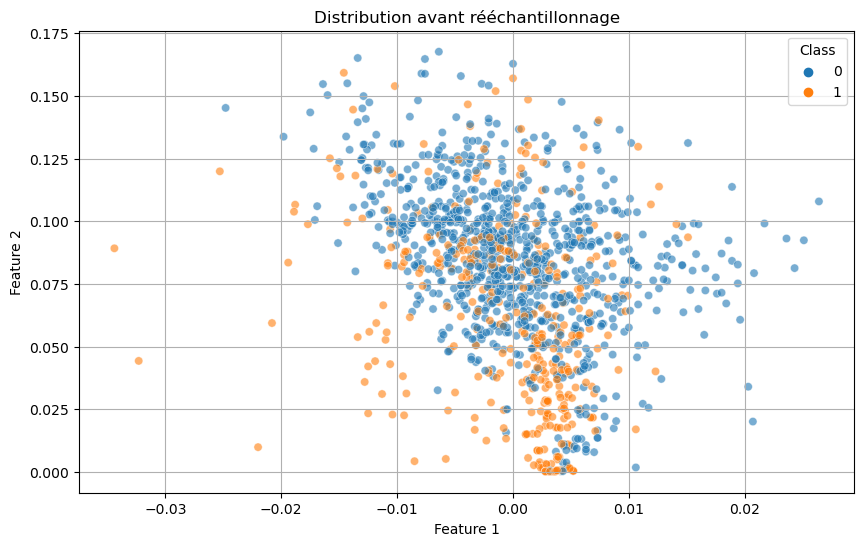

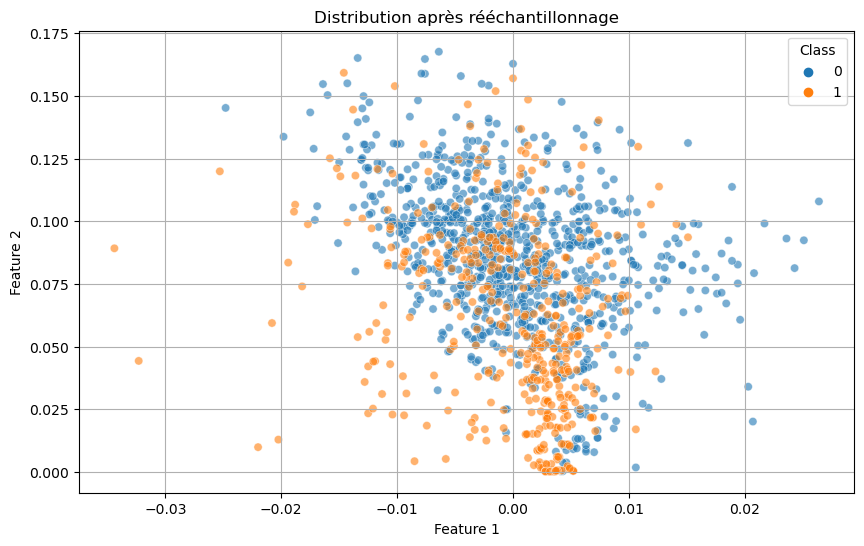

In [5]:
# Fonction pour créer un nuage de points
import matplotlib.pyplot as plt
import seaborn as sns

def plot_data(X, y, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, alpha=0.6)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(title='Class')
    plt.grid(True)
    plt.show()
    
# Choisissez les deux premières caractéristiques pour la visualisation si vous avez plus de deux dimensions
plot_data(X_train_avant_resample.iloc[:, :2].values, y_train_avant_resample, "Distribution avant rééchantillonnage")
plot_data(X_resampled.iloc[:, :2].values, y_resampled, "Distribution après rééchantillonnage")

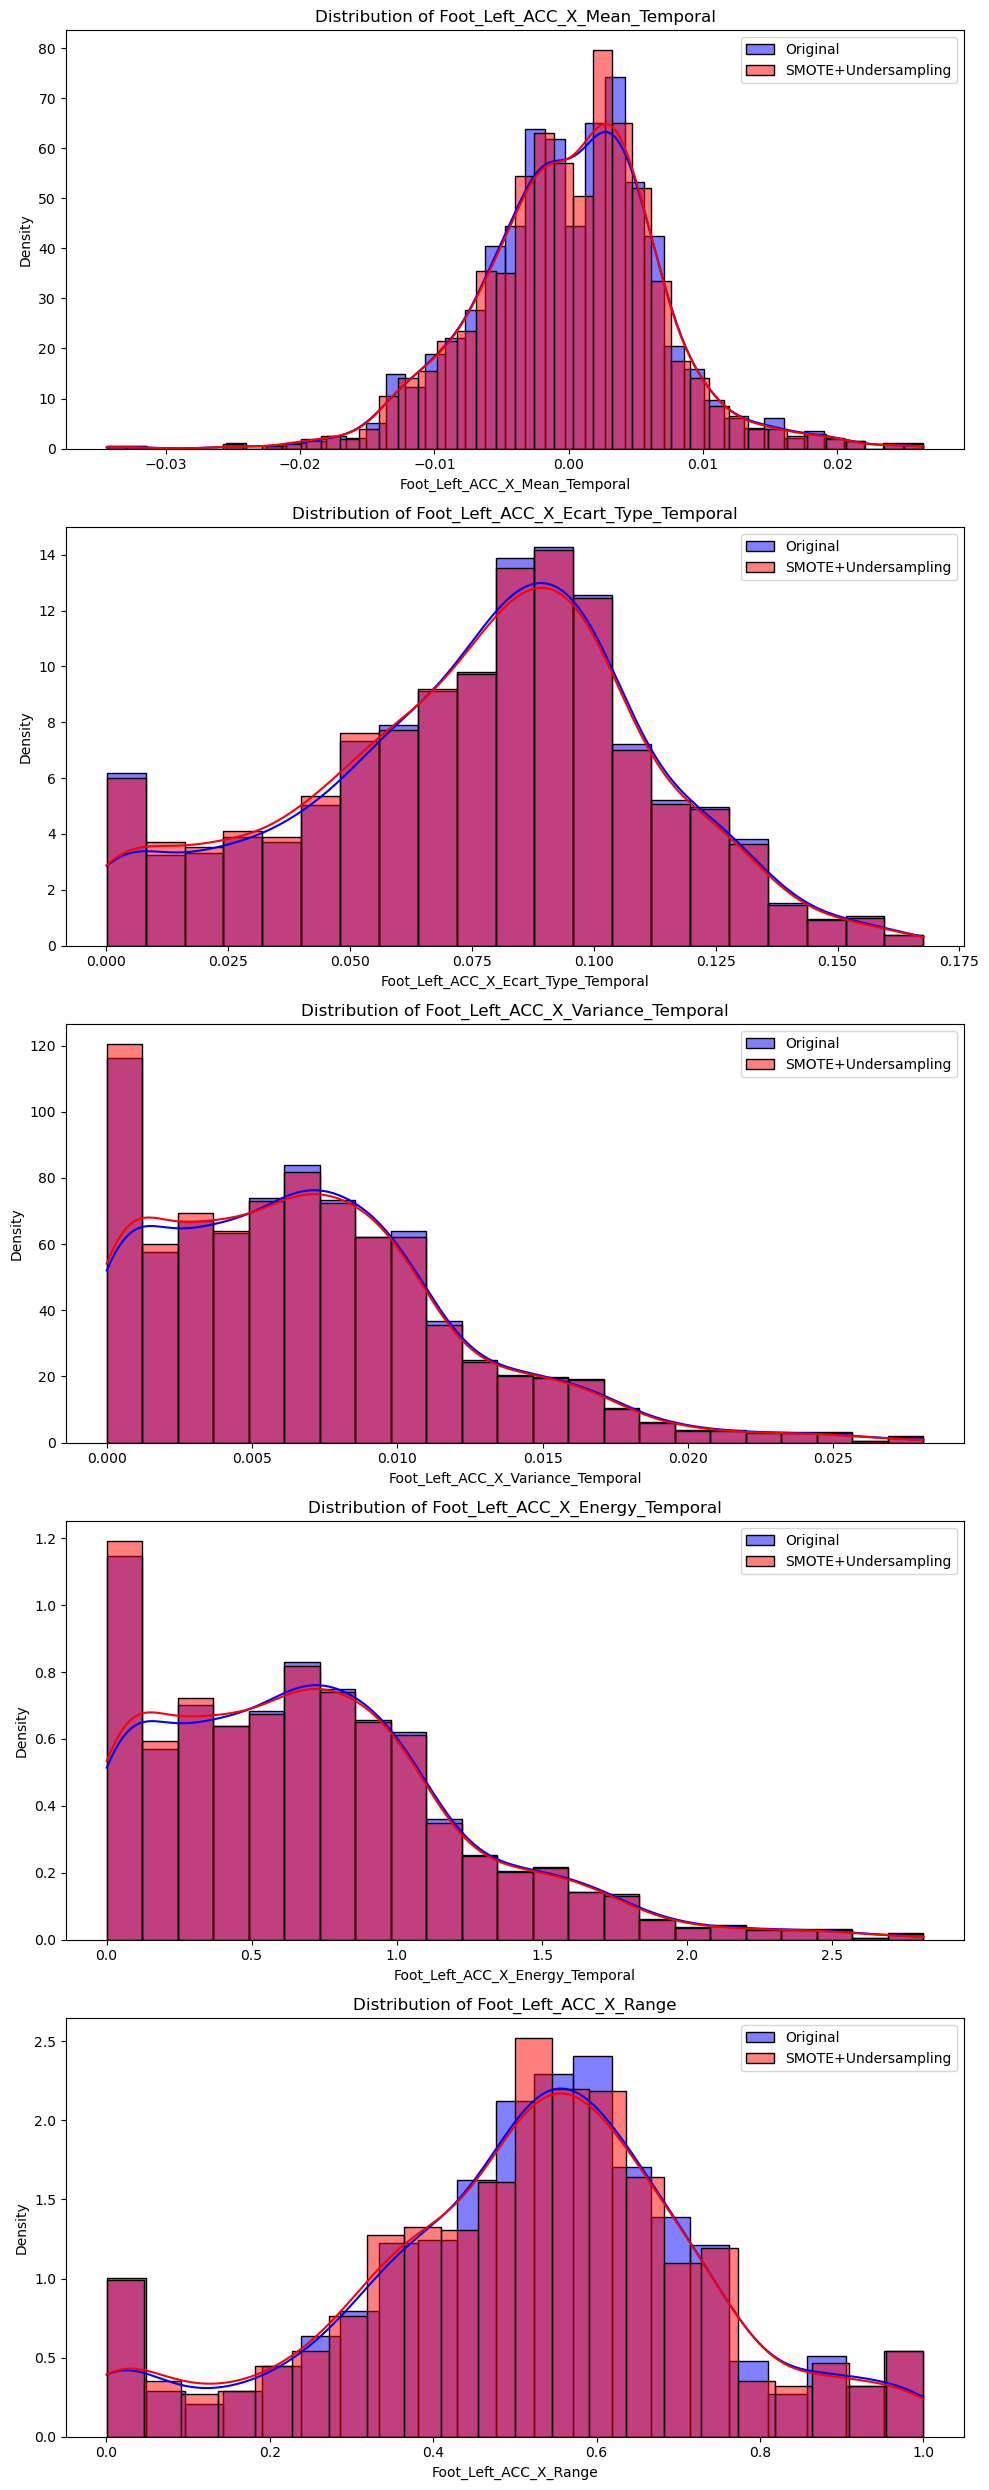

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélection des 10 premières caractéristiques de X_train (ajustez si nécessaire pour votre DataFrame)
features_to_plot = X_train_avant_resample.columns[:5]  # Modifiez selon le nombre réel de colonnes si nécessaire

# Fonction pour tracer les distributions des caractéristiques
def plot_feature_distributions(df1, df2, feature_names, df1_label='Original', df2_label='SMOTE+Undersampling'):
    fig, axes = plt.subplots(nrows=len(feature_names), ncols=1, figsize=(10, 5 * len(feature_names)))
    for i, feature in enumerate(feature_names):
        ax = axes[i] if len(feature_names) > 1 else axes
        sns.histplot(df1[feature], color="blue", label=df1_label, kde=True, ax=ax, stat="density", common_norm=False)
        sns.histplot(df2[feature], color="red", label=df2_label, kde=True, ax=ax, stat="density", common_norm=False)
        ax.set_title(f'Distribution of {feature}')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Appel de la fonction pour tracer les distributions des 10 premières caractéristiques
plot_feature_distributions(X_train_avant_resample, X_resampled, features_to_plot)

Minority class: 1


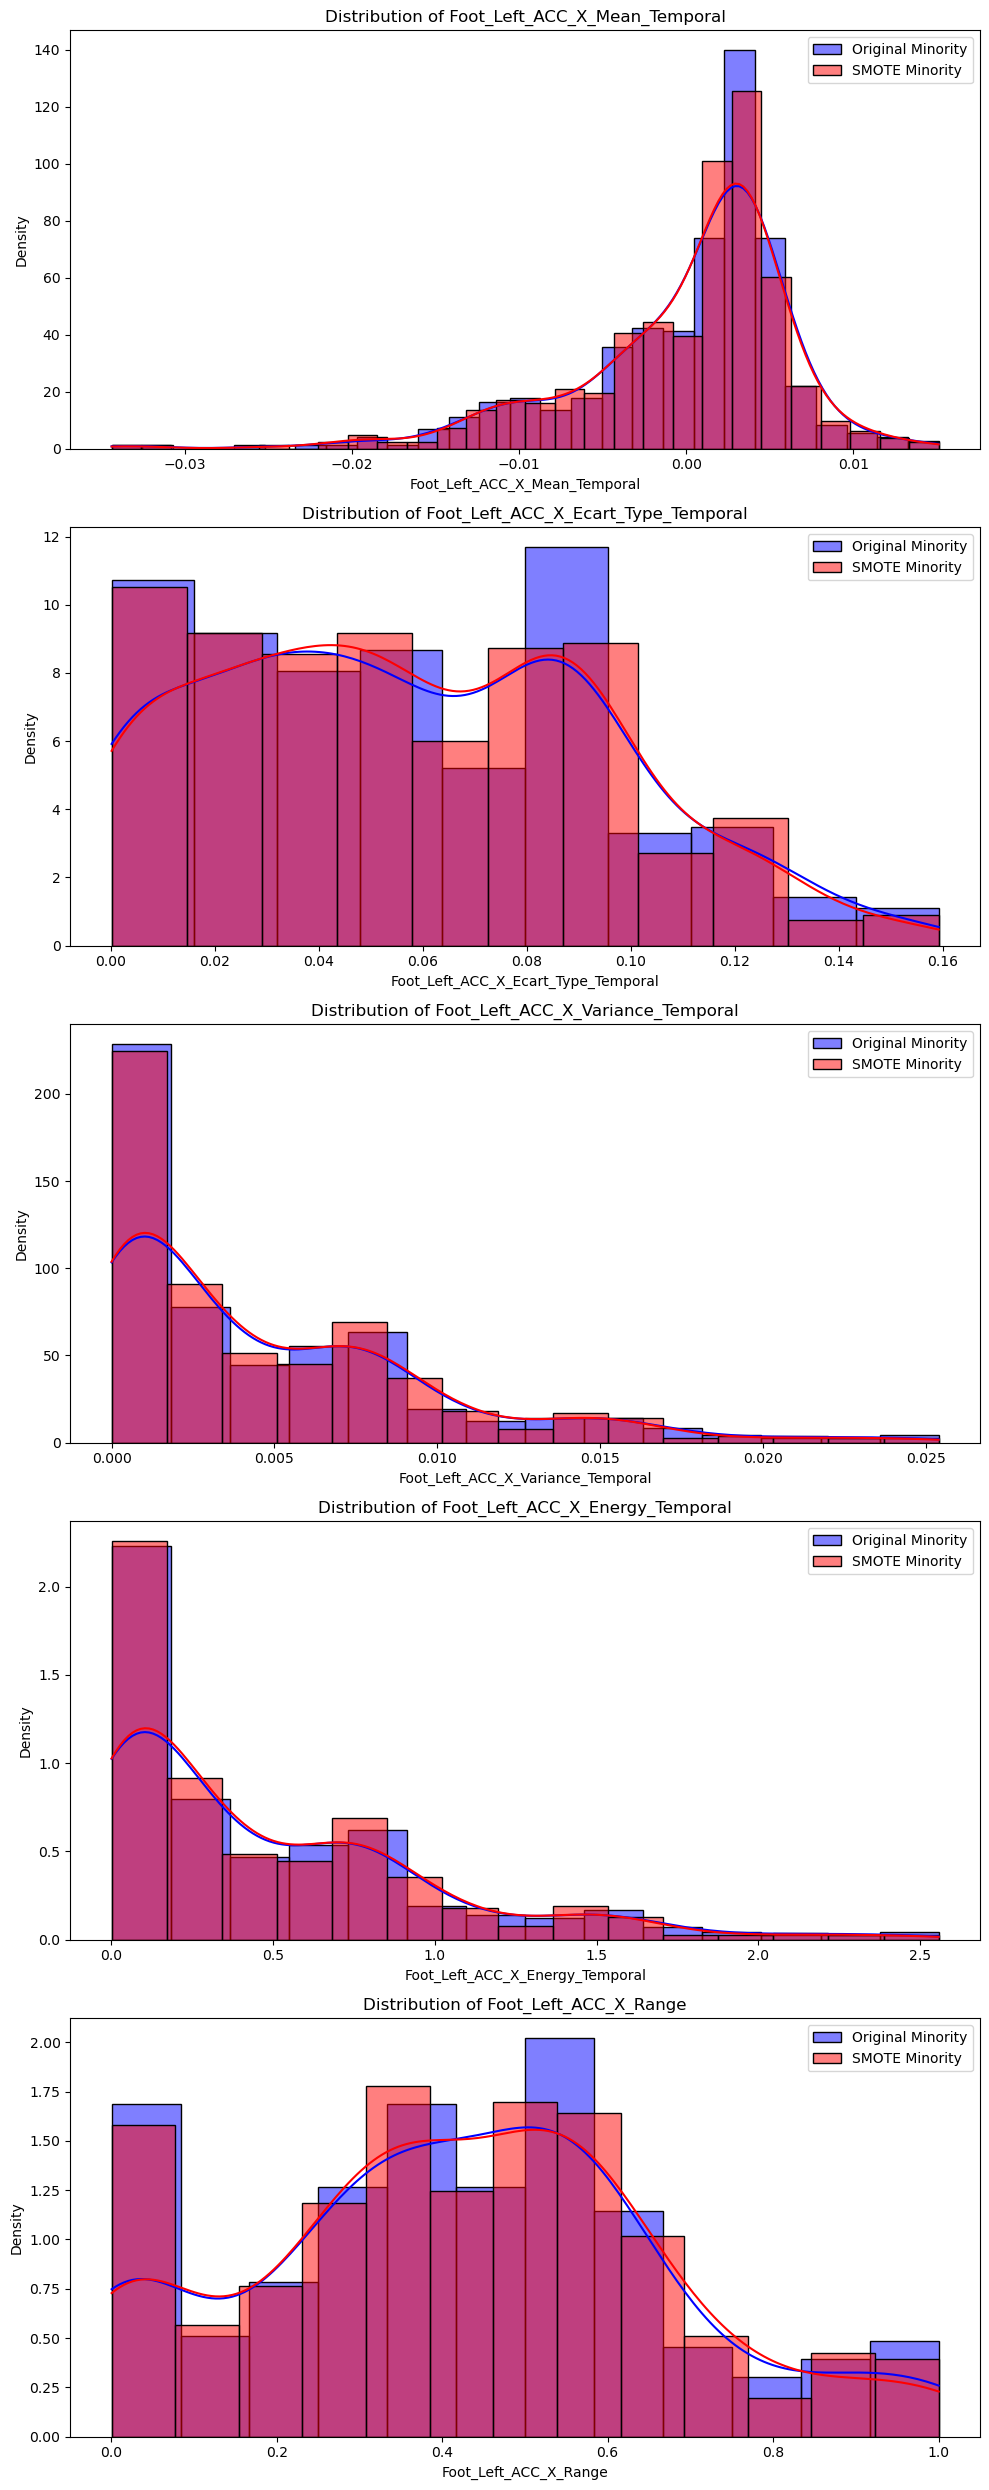

In [25]:
'''Visualisation de la classe minoritaire'''
# Identifier la classe minoritaire
minority_class = y_train_avant_resample.value_counts().idxmin()
print( "Minority class:", minority_class)
# Filtrer les données de la classe minoritaire dans les données originales
X_minority_original = X_train_avant_resample[y_train_avant_resample == minority_class]

# Filtrer les données de la classe minoritaire dans les données SMOTE
# Supposons que X_smote_added et y_smote_added soient les données après SMOTE
X_minority_smote = X_resampled[y_resampled == minority_class]

# Sélection des 10 premières caractéristiques pour la visualisation
features_to_plot = X_train_avant_resample.columns[:5]

# Fonction pour tracer les distributions des caractéristiques
def plot_feature_distributions(df1, df2, feature_names, df1_label='Original Minority', df2_label='SMOTE Minority'):
    fig, axes = plt.subplots(nrows=len(feature_names), ncols=1, figsize=(10, 5 * len(feature_names)))
    for i, feature in enumerate(feature_names):
        ax = axes[i] if len(feature_names) > 1 else axes
        sns.histplot(df1[feature], color="blue", label=df1_label, kde=True, ax=ax, stat="density", common_norm=False)
        sns.histplot(df2[feature], color="red", label=df2_label, kde=True, ax=ax, stat="density", common_norm=False)
        ax.set_title(f'Distribution of {feature}')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Appeler la fonction de visualisation
plot_feature_distributions(X_minority_original, X_minority_smote, features_to_plot)

# _______________________________________________________________________________________________________________________________________________________

# _________________________________________________________________________________________________________________________________________________________

# _____________________________________________________________________________________________________________________________________________________

# ________________________________________________________________________________________________________________________________________________________

# Relief F avec resample optimisé pour chaque fichier

In [43]:
# On test avec fichier quelconque
X_resampled = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_P_P_1963-04-01_OFF_OFF_all_extraction_features.csv')
y_resampled = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/y_train_P_P_1963-04-01_OFF_OFF_all_extraction_features.csv')
X_test = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/X_test_P_P_1963-04-01_OFF_OFF_all_extraction_features.csv')
y_test = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/y_test_P_P_1963-04-01_OFF_OFF_all_extraction_features.csv')

In [44]:
X_resampled_np = X_resampled.values if isinstance(X_resampled, pd.DataFrame) else X_resampled

# Assuming the DataFrame y_resampled has one column named 'label'
if isinstance(y_resampled, pd.DataFrame):
    y_resampled_np = y_resampled['label'].values  # Directly accessing the column
else:
    y_resampled_np = y_resampled  # No change needed if already correct formatgrid_search.fit(X_resampled_np, y_resampled_np)

X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# Assuming the DataFrame y_resampled has one column named 'label'
if isinstance(y_test, pd.DataFrame):
    y_test_np = y_test['label'].values  # Directly accessing the column
else:
    y_test_np = y_test  # No change needed if already correct format
    
reliefF = ReliefF()

# Étape 2: Fit ReliefF sur l'ensemble d'entraînement complet
reliefF.fit(X_resampled_np, y_resampled_np)

# Obtention des scores de l'importance des caractéristiques
feature_scores = reliefF.feature_importances_

# Création d'un DataFrame pour mieux visualiser les scores des caractéristiques
feature_importance_df = pd.DataFrame(feature_scores, index=X_resampled.columns, columns=["Importance"])
feature_importance_df.sort_values("Importance", ascending=False, inplace=True)

import plotly.express as px

# Sélectionner les 10 premières caractéristiques les plus importantes
top_features = feature_importance_df.nlargest(20, 'Importance')

# Arrondir les valeurs d'importance à deux décimales
top_features['Importance'] = top_features['Importance'].round(2)

# Création du graphique en barres horizontales interactif avec Plotly
fig = px.bar(top_features, y=top_features.index, x='Importance', 
             text='Importance',  # Afficher les scores sur les barres
             orientation='h',  # Créer des barres horizontales
             labels={'y': 'Features', 'Importance': 'Importance Score'},
             title='Top 15 Most Important Features',
             color='Importance',  # Utiliser les valeurs d'importance pour la couleur
             height=500)  # Ajuster la hauteur si nécessaire

# Améliorer le format des textes sur les barres pour les arrondir
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')

# Inverser l'axe y pour que la caractéristique la plus importante soit en haut
fig.update_layout(yaxis={'categoryorder':'total ascending'})

# Afficher le graphique
fig.show()


# Tableau qui stock les résultats de Relief F et la distribution des classes pour les resamples optimisé

In [62]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skrebate import ReliefF

def apply_resampling_pipeline(filepath_X_train, filepath_y_train):
    print(f"Traitement du fichier {filepath_X_train} et {filepath_y_train} ...")  # Début de traitement
    
    # Charger les données d'entraînement
    X_train = pd.read_csv(filepath_X_train)
    y_train = pd.read_csv(filepath_y_train)
    
    # ReliefF feature importance
    reliefF = ReliefF()
    reliefF.fit(X_train.values, y_train['label'].values)
    feature_scores = reliefF.feature_importances_

    feature_importance_df = pd.DataFrame(feature_scores, index=X_train.columns, columns=["Importance"])
    feature_importance_df.sort_values("Importance", ascending=False, inplace=True)

    top_features = feature_importance_df.nlargest(20, 'Importance')
    top_features['Importance'] = top_features['Importance'].round(2)

    print(f"Traitement terminé pour {filepath_X_train}.")  # Fin de traitement
    return y_train['label'].value_counts().to_dict(), top_features

# Chemin du répertoire où se trouvent les fichiers de données
directory_path = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/'

# DataFrame pour stocker les résultats
results_df = pd.DataFrame()

# Traitement de chaque fichier
for filename in os.listdir(directory_path):
    if filename.startswith("X_train"):
        base_name = filename[len("X_train_"):-4]  # Extraire la base du nom sans 'X_train_' et '.csv'
        filepath_X_train = os.path.join(directory_path, filename)
        filepath_y_train = os.path.join(directory_path, f"y_train_{base_name}.csv")
        
        label_counts, top_features = apply_resampling_pipeline(filepath_X_train, filepath_y_train)
        results_df = results_df.append({
            'File': base_name,
            'Label Counts': label_counts,
            'Top Features Importance': top_features
        }, ignore_index=True)

        print(f"Added results for {base_name} to the DataFrame.")  # Confirmation de l'ajout des résultats

# Enregistrer les résultats DataFrame dans un fichier CSV
results_file = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/resultats_relief_f/results_relief_f_avec_resample_optimise.csv'
results_df.to_csv(results_file, index=False)
print(f"Results saved to {results_file}.")  # Confirmation de l'enregistrement des résultats


Traitement du fichier C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_A_P_1956-02-21_ON_ON_all_extraction_features.csv et C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/y_train_A_P_1956-02-21_ON_ON_all_extraction_features.csv ...
Traitement terminé pour C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_A_P_1956-02-21_ON_ON_all_extraction_features.csv.
Added results for A_P_1956-02-21_ON_ON_all_extraction_features to the DataFrame.
Traitement du fichier C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_L_J_1942-01-17_ON_ON_all_extraction_features.csv et C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/y_train_L_J_1942-01-17_ON_ON_all_extraction_features.csv ...


C:\Users\antho\AppData\Local\Temp\ipykernel_22832\2792642405.py:42: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Traitement terminé pour C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_L_J_1942-01-17_ON_ON_all_extraction_features.csv.
Added results for L_J_1942-01-17_ON_ON_all_extraction_features to the DataFrame.
Traitement du fichier C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_P_P_1963-04-01_OFF_OFF_all_extraction_features.csv et C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/y_train_P_P_1963-04-01_OFF_OFF_all_extraction_features.csv ...


C:\Users\antho\AppData\Local\Temp\ipykernel_22832\2792642405.py:42: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Traitement terminé pour C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_P_P_1963-04-01_OFF_OFF_all_extraction_features.csv.
Added results for P_P_1963-04-01_OFF_OFF_all_extraction_features to the DataFrame.
Traitement du fichier C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_P_P_1963-04-01_ON_ON_all_extraction_features.csv et C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/y_train_P_P_1963-04-01_ON_ON_all_extraction_features.csv ...


C:\Users\antho\AppData\Local\Temp\ipykernel_22832\2792642405.py:42: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Traitement terminé pour C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_P_P_1963-04-01_ON_ON_all_extraction_features.csv.
Added results for P_P_1963-04-01_ON_ON_all_extraction_features to the DataFrame.
Traitement du fichier C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_R_J_1961-10-0802RJ_OFF_OFF_all_extraction_features.csv et C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/y_train_R_J_1961-10-0802RJ_OFF_OFF_all_extraction_features.csv ...


C:\Users\antho\AppData\Local\Temp\ipykernel_22832\2792642405.py:42: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Traitement terminé pour C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_R_J_1961-10-0802RJ_OFF_OFF_all_extraction_features.csv.
Added results for R_J_1961-10-0802RJ_OFF_OFF_all_extraction_features to the DataFrame.
Traitement du fichier C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_R_J_1961-10-0802RJ_ON_ON_all_extraction_features.csv et C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/y_train_R_J_1961-10-0802RJ_ON_ON_all_extraction_features.csv ...


C:\Users\antho\AppData\Local\Temp\ipykernel_22832\2792642405.py:42: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Traitement terminé pour C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_R_J_1961-10-0802RJ_ON_ON_all_extraction_features.csv.
Added results for R_J_1961-10-0802RJ_ON_ON_all_extraction_features to the DataFrame.
Results saved to C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/resultats_relief_f/results_relief_f_avec_resample_optimise_test.csv.


C:\Users\antho\AppData\Local\Temp\ipykernel_22832\2792642405.py:42: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



# Relief F avec un resample manuel

In [46]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skrebate import ReliefF
import plotly.express as px

def apply_resampling_pipeline(filepath):
    data = pd.read_csv(filepath)
    data_filtered = data.dropna(axis=1)
    data_filtered = data_filtered[data_filtered['label'] != 'transitionNoFog']
    X = data_filtered.drop('label', axis=1)
    y = data_filtered['label'].apply(lambda x: 1 if x in ['fog', 'transitionFog'] else 0)
    
    #réinitialiser l'index après le filtrage
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    
    #Normalisation
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)  
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)
    
    # Afficher la distribution avant le resampling
    print("Distribution before resampling:")
    print(y_train.value_counts())
    
    # Déterminer le ratio de sous-échantillonnage
    smote = SMOTE(sampling_strategy=0.9, random_state=42)
    under_sampler = RandomUnderSampler(sampling_strategy=0.9, random_state=42)
    pipeline = Pipeline([
        ('smote', smote),
        ('under_sampler', under_sampler)
    ])

    X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)
        # Afficher la distribution après le resampling
        
    # smo = SMOTE(random_state=42)),
    print("Distribution after resampling:")
    print(y_resampled.value_counts())
    print("Finished processing:", filepath)
    return X_resampled.reset_index(drop=True), y_resampled.reset_index(drop=True), X_test.reset_index(drop=True), y_test.reset_index(drop=True)

# Example usage
file_path = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/P_P_1963-04-01_OFF_OFF_all_extraction_features.csv'
X_resampled, y_resampled, X_test, y_test = apply_resampling_pipeline(file_path)

# Assuming y_train is not a DataFrame
X_train_np = X_resampled.values
y_train_np = y_resampled.values if not isinstance(y_resampled, pd.DataFrame) else y_resampled['label'].values

reliefF = ReliefF()
reliefF.fit(X_train_np, y_train_np)
feature_scores = reliefF.feature_importances_
feature_importance_df = pd.DataFrame(feature_scores, index=X_resampled.columns, columns=["Importance"])
feature_importance_df.sort_values("Importance", ascending=False, inplace=True)

top_features = feature_importance_df.nlargest(30, 'Importance')
top_features['Importance'] = top_features['Importance'].round(2)

# Création du graphique en barres horizontales interactif avec Plotly
fig = px.bar(top_features, y=top_features.index, x='Importance', 
             text='Importance',  # Afficher les scores sur les barres
             orientation='h',  # Créer des barres horizontales
             labels={'y': 'Features', 'Importance': 'Importance Score'},
             title='Top 30 Most Important Features',
             color='Importance',  # Utiliser les valeurs d'importance pour la couleur
             height=500)  # Ajuster la hauteur si nécessaire

# Améliorer le format des textes sur les barres pour les arrondir
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')

# Inverser l'axe y pour que la caractéristique la plus importante soit en haut
fig.update_layout(yaxis={'categoryorder':'total ascending'})

# Afficher le graphique
fig.show()

Distribution before resampling:
0    1203
1     500
Name: label, dtype: int64
Distribution after resampling:
0    1202
1    1082
Name: label, dtype: int64
Finished processing: C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/P_P_1963-04-01_OFF_OFF_all_extraction_features.csv


# Tableau qui stock les résultats de Relief F et la distribution des classes pour les resamples manuels

In [64]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE
from skrebate import ReliefF

def apply_resampling_pipeline(filepath):
    print(f"Traitement du fichier {filepath}...")
    data = pd.read_csv(filepath)
    data_filtered = data.dropna(axis=1)
    data_filtered = data_filtered[data_filtered['label'] != 'transitionNoFog']
    X = data_filtered.drop('label', axis=1)
    y = data_filtered['label'].apply(lambda x: 1 if x in ['fog', 'transitionFog'] else 0)


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

    rus = BorderlineSMOTE(sampling_strategy=1, random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    reliefF = ReliefF()
    reliefF.fit(X_resampled, y_resampled)
    feature_scores = reliefF.feature_importances_

    feature_importance_df = pd.DataFrame(feature_scores, index=X.columns, columns=["Importance"]).sort_values(by="Importance", ascending=False)
    return feature_importance_df.head(30).round(2), y_train.value_counts().to_dict(), y_resampled.value_counts().to_dict(), y_test.value_counts().to_dict()

# Directory path
directory_path = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/'

# DataFrame to store the results
results_df = pd.DataFrame(columns=['File',
                                   'Nb de chaque label avant la séparation en train et test', 
                                   'Before Resampling du train', 'After Resampling du train',
                                   'Nb de chaque label de test', 
                                   'Top Features Importance'])

# Process each file
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory_path, filename)
        print(f"Processing {filename}...")  # Affiche le nom du fichier en cours de traitement
        before_resampling, after_resampling,label_counts_test, top_features, label_counts = apply_resampling_pipeline(filepath)
        results_df = results_df.append({
            'File': filename,
            'Nb de chaque label avant la séparation en train et test' :  label_counts,
            'Before Resampling du train': before_resampling,
            'After Resampling du train': after_resampling,
            'Nb de chaque label de test': label_counts_test,
            'Top Features Importance': top_features
        }, ignore_index=True)
        print(f"Added results for {filename} to the DataFrame.")  # Confirme l'ajout des résultats

results_file = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/resultats_relief_f/results_relief_f_bordersmote_100.csv'
results_df.to_csv(results_file, index=False)
print(f"Results saved to {results_file}.")


Processing A_P_1956-02-21_ON_ON_all_extraction_features.csv...
Traitement du fichier C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/A_P_1956-02-21_ON_ON_all_extraction_features.csv...


KeyboardInterrupt: 

In [ ]:
# import os
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import SMOTE, BorderlineSMOTE
# from skrebate import ReliefF

# def apply_resampling_pipeline(filepath):
#     print(f"Traitement du fichier {filepath}...")  # Ajout d'un message de début de traitement
#     data = pd.read_csv(filepath)
#     data_filtered = data.dropna(axis=1)
#     data_filtered = data_filtered[data_filtered['label'] != 'transitionNoFog']
#     X = data_filtered.drop('label', axis=1)
#     y = data_filtered['label'].apply(lambda x: 1 if x in ['fog', 'transitionFog'] else 0)


#     label_counts = data_filtered['label'].value_counts().to_dict()

#     scaler = StandardScaler()
#     X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#     X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

#     # Resampling
#     rus = BorderlineSMOTE(sampling_strategy=1, random_state=42)
#     X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

#     # ReliefF feature importance
#     reliefF = ReliefF(n_features_to_select=30)
#     reliefF.fit(X_resampled.values, y_resampled.values)
#     feature_scores = reliefF.feature_importances_

#     feature_importance_df = pd.DataFrame(feature_scores, index=X_train.columns, columns=["Importance"])
#     feature_importance_df.sort_values("Importance", ascending=False, inplace=True)

#     top_features = feature_importance_df.nlargest(30, 'Importance')
#     top_features['Importance'] = top_features['Importance'].round(2)

#     print(f"Traitement terminé pour {filepath}.")  # Ajout d'un message de fin de traitement
#     return y_train.value_counts().to_dict(), y_resampled.value_counts().to_dict(), y_test.value_counts().to_dict(),top_features, label_counts

# # Process the specified file
# filename = os.path.basename(filepath)
# print(f"Processing {filename}...")
# before_resampling, after_resampling, label_counts_test, top_features, label_counts = apply_resampling_pipeline(filepath)
# for index, row in top_features.iterrows():
#     results_df = results_df.append({
#         'File': filename,
#         'Feature': index,  # Utilisez directement l'index ici
#         'Importance': row['Importance'],  # Accès direct à la colonne 'Importance'
#         'Label Counts Train Before Resampling': before_resampling,
#         'Label Counts Train After Resampling': after_resampling,
#         'Label Counts Test': label_counts_test
#     }, ignore_index=True)
# print(f"Added results for {filename} to the DataFrame.")

# # Directory path
# directory_path = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/'

# # Process each file
# for filename in os.listdir(directory_path):
#     if filename.endswith(".csv"):
#         filepath = os.path.join(directory_path, filename)
#         print(f"Processing {filename}...")  # Affiche le nom du fichier en cours de traitement
#         before_resampling, after_resampling,label_counts_test, top_features, label_counts = apply_resampling_pipeline(filepath)
#         for index, row in top_features.iterrows():
#             results_df = results_df.append({
#                 'File': filename,
#                 'Feature': index,  # Utilisez directement l'index ici
#                 'Importance': row['Importance'],  # Accès direct à la colonne 'Importance'
#                 'Label Counts Train Before Resampling': before_resampling,
#                 'Label Counts Train After Resampling': after_resampling,
#                 'Label Counts Test': label_counts_test
#             }, ignore_index=True)
#         print(f"Added results for {filename} to the DataFrame.")  # Confirme l'ajout des résultats

# # Save the results DataFrame to an Excel file
# results_file = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/resultats_relief_f/results_relief_f_bordersmote_100.csv'
# results_df.to_csv(results_file, index=False)
# print(f"Results saved to {results_file}.")  # Confirme que les résultats ont été enregistrés


Processing R_J_1961-10-0802RJ_ON_ON_all_extraction_features.csv...
Traitement du fichier C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/R_J_1961-10-0802RJ_ON_ON_all_extraction_features.csv...
Traitement terminé pour C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/R_J_1961-10-0802RJ_ON_ON_all_extraction_features.csv.
Added results for R_J_1961-10-0802RJ_ON_ON_all_extraction_features.csv to the DataFrame.
Processing A_P_1956-02-21_ON_ON_all_extraction_features.csv...
Traitement du fichier C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/A_P_1956-02-21_ON_ON_all_extraction_features.csv...


C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

Traitement terminé pour C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/A_P_1956-02-21_ON_ON_all_extraction_features.csv.
Added results for A_P_1956-02-21_ON_ON_all_extraction_features.csv to the DataFrame.
Processing L_J_1942-01-17_ON_ON_all_extraction_features.csv...
Traitement du fichier C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/L_J_1942-01-17_ON_ON_all_extraction_features.csv...


C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

Traitement terminé pour C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/L_J_1942-01-17_ON_ON_all_extraction_features.csv.
Added results for L_J_1942-01-17_ON_ON_all_extraction_features.csv to the DataFrame.
Processing P_P_1963-04-01_OFF_OFF_all_extraction_features.csv...
Traitement du fichier C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/P_P_1963-04-01_OFF_OFF_all_extraction_features.csv...


C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

Traitement terminé pour C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/P_P_1963-04-01_OFF_OFF_all_extraction_features.csv.
Added results for P_P_1963-04-01_OFF_OFF_all_extraction_features.csv to the DataFrame.
Processing P_P_1963-04-01_ON_ON_all_extraction_features.csv...
Traitement du fichier C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/P_P_1963-04-01_ON_ON_all_extraction_features.csv...


C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

Traitement terminé pour C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/P_P_1963-04-01_ON_ON_all_extraction_features.csv.
Added results for P_P_1963-04-01_ON_ON_all_extraction_features.csv to the DataFrame.
Processing R_J_1961-10-0802RJ_OFF_OFF_all_extraction_features.csv...
Traitement du fichier C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/R_J_1961-10-0802RJ_OFF_OFF_all_extraction_features.csv...


C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

Traitement terminé pour C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/R_J_1961-10-0802RJ_OFF_OFF_all_extraction_features.csv.
Added results for R_J_1961-10-0802RJ_OFF_OFF_all_extraction_features.csv to the DataFrame.
Processing R_J_1961-10-0802RJ_ON_ON_all_extraction_features.csv...
Traitement du fichier C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/R_J_1961-10-0802RJ_ON_ON_all_extraction_features.csv...


C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

Traitement terminé pour C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/R_J_1961-10-0802RJ_ON_ON_all_extraction_features.csv.
Added results for R_J_1961-10-0802RJ_ON_ON_all_extraction_features.csv to the DataFrame.
Results saved to C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/resultats_relief_f/results_relief_f_bordersmote_100.csv.


C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\antho\AppData\Local\Temp\ipykernel_22832\3349368681.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

# _______________________________________________________________________________________________________________________________________________________________________________

# ___________________________________________________________________________________________________________________________________________________

# Commencement du Batch Process

# Ajout des données FOG et Suppression des données NOFOG grâce à SMOTE combinés avec RandomUnderSampler

In [11]:
def display_class_distribution(filepath):
    try:
        # Lecture des données
        data = pd.read_csv(filepath)
        data_filtered = data.dropna(axis=1)
        data_filtered = data_filtered[data_filtered['label'] != 'transitionNoFog']
        
        # Reset index after filtering
        data_filtered.reset_index(drop=True, inplace=True)

        X = data_filtered.drop('label', axis=1)
        y = data_filtered['label'].apply(lambda x: 1 if x in ['fog', 'transitionFog'] else 0)

        # Affichage de la distribution des classes
        print(f"File: {os.path.basename(filepath)} - Distribution des classes avant le pipeline:", y.value_counts())
    except Exception as e:
        print(f"Erreur lors de l'affichage de la distribution pour {os.path.basename(filepath)}: {str(e)}")

data_directory = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features'

# Affichage de la distribution des classes pour chaque fichier
for filename in os.listdir(data_directory):
    file_path = os.path.join(data_directory, filename)
    display_class_distribution(file_path)

File: A_P_1956-02-21_ON_ON_all_extraction_features.csv - Distribution des classes avant le pipeline: 0    1315
1     568
Name: label, dtype: int64
File: L_J_1942-01-17_ON_ON_all_extraction_features.csv - Distribution des classes avant le pipeline: 0    3477
1     101
Name: label, dtype: int64
File: P_P_1963-04-01_OFF_OFF_all_extraction_features.csv - Distribution des classes avant le pipeline: 0    1719
1     714
Name: label, dtype: int64
File: P_P_1963-04-01_ON_ON_all_extraction_features.csv - Distribution des classes avant le pipeline: 0    1947
1     369
Name: label, dtype: int64
File: R_J_1961-10-0802RJ_OFF_OFF_all_extraction_features.csv - Distribution des classes avant le pipeline: 1    1995
0    1954
Name: label, dtype: int64
File: R_J_1961-10-0802RJ_ON_ON_all_extraction_features.csv - Distribution des classes avant le pipeline: 1    718
0    571
Name: label, dtype: int64


# Batch process du resample pour les conditions ON et OFF de chaque patient (Sample et UnderSampler)

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.exceptions import NotFittedError

def apply_resampling_pipeline(filepath, index, total_files):
    try:
        filename = os.path.basename(filepath)
        base_filename = filename.replace('_all_extraction_features', '')
        print(f"Processing {index}/{total_files}: {filename}")

        # Lecture des données
        data = pd.read_csv(filepath)
        data_filtered = data.dropna(axis=1)
        data_filtered = data_filtered[data_filtered['label'] != 'transitionNoFog']
        
        # Reset index after filtering
        data_filtered.reset_index(drop=True, inplace=True)

        X = data_filtered.drop('label', axis=1)
        y = data_filtered['label'].apply(lambda x: 1 if x in ['fog', 'transitionFog'] else 0)

        # Normalize the features
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)  

        # Séparation des données en ensembles d'entraînement et de test
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42)

        # Configuration du pipeline final avec les paramètres optimaux
        print("Applying resampling pipeline...")
        final_pipeline = Pipeline([
            ('smote', BorderlineSMOTE(sampling_strategy=0.5, random_state=42)),
            ('under_sampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42))
        ])

        # Application du pipeline sur les données d'entraînement
        X_resampled, y_resampled = final_pipeline.fit_resample(X_train, y_train)
        
        # Sauvegarde des fichiers
        print("Saving resampled data...")
        train_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_{base_filename}"
        pd.DataFrame(X_resampled).to_csv(train_path, index=False, header=True)
        train_label_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/y_train_{base_filename}"
        pd.Series(y_resampled).to_csv(train_label_path, index=False, header=True)

        test_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/X_test_{base_filename}"
        pd.DataFrame(X_test).to_csv(test_path, index=False, header=True)
        test_label_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/y_test_{base_filename}"
        pd.Series(y_test).to_csv(test_label_path, index=False, header=True)
        
        print("Finished processing:", filename)
        
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")

# Chemin vers les fichiers de données
data_directory = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features'
files = os.listdir(data_directory)
total_files = len(files)

# Traitement de chaque fichier dans le répertoire
for index, filename in enumerate(files, start=1):
    file_path = os.path.join(data_directory, filename)
    apply_resampling_pipeline(file_path, index, total_files)


In [18]:
# import os
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline
# from sklearn.exceptions import NotFittedError

# def apply_resampling_pipeline(filepath, index, total_files):
#     try:
#         filename = os.path.basename(filepath)
#         base_filename = filename.replace('_all_extraction_features', '')
#         print(f"Processing {index}/{total_files}: {filename}")

#         # Lecture des données
#         data = pd.read_csv(filepath)
#         data_filtered = data.dropna(axis=1)
#         data_filtered = data_filtered[data_filtered['label'] != 'transitionNoFog']
        
#         # Reset index after filtering
#         data_filtered.reset_index(drop=True, inplace=True)

#         X = data_filtered.drop('label', axis=1)
#         y = data_filtered['label'].apply(lambda x: 1 if x in ['fog', 'transitionFog'] else 0)

#         # Normalize the features
#         scaler = StandardScaler()
#         X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)  

#         # Séparation des données en ensembles d'entraînement et de test
#         X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42)

#         # Calcul du ratio des classes cibles, si le ratio est supérieur à 0.5, pas besoin de resampling, cela voudra dire qu'il y a suffisemment de fenêtres FOG
#         class_ratio = y_train.value_counts(normalize=True)
#         if class_ratio.get(1, 0) > 0.5:
#             print("No need to resample, class ratio is sufficient.")
#             print("Saving resampled data wirh no resampling...")
#             train_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_{base_filename}"
#             pd.DataFrame(X_train).to_csv(train_path, index=False, header=True)
#             train_label_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/y_train_{base_filename}"
#             pd.Series(y_train).to_csv(train_label_path, index=False, header=True)

#             test_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/X_test_{base_filename}"
#             pd.DataFrame(X_test).to_csv(test_path, index=False, header=True)
#             test_label_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/y_test_{base_filename}"
#             pd.Series(y_test).to_csv(test_label_path, index= False, header=True)
            
#             print("Finished processing:", filename)
#             return  # Termine la fonction si la condition est remplie

#         # Configuration du pipeline final avec les paramètres optimaux
#         print("Applying resampling pipeline...")
#         final_pipeline = Pipeline([
#             ('smote', BorderlineSMOTE(sampling_strategy=0.5, random_state=42)),
#             ('under_sampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42))
#         ])

#         # Application du pipeline sur les données d'entraînement
#         X_resampled, y_resampled = final_pipeline.fit_resample(X_train, y_train)
        
#         # Sauvegarde des fichiers
#         print("Saving resampled data...")
#         train_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_{base_filename}"
#         pd.DataFrame(X_resampled).to_csv(train_path, index=False, header=True)
#         train_label_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/y_train_{base_filename}"
#         pd.Series(y_resampled).to_csv(train_label_path, index=False, header=True)

#         test_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/X_test_{base_filename}"
#         pd.DataFrame(X_test).to_csv(test_path, index=False, header=True)
#         test_label_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/y_test_{base_filename}"
#         pd.Series(y_test).to_csv(test_label_path, index=False, header=True)
        
#         print("Finished processing:", filename)
        
#     except Exception as e:
#         print(f"Error processing {filename}: {str(e)}")

# # Chemin vers les fichiers de données
# data_directory = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features'
# files = os.listdir(data_directory)
# total_files = len(files)

# # Traitement de chaque fichier dans le répertoire
# for index, filename in enumerate(files, start=1):
#     file_path = os.path.join(data_directory, filename)
#     apply_resampling_pipeline(file_path, index, total_files)


Processing 1/6: A_P_1956-02-21_ON_ON_all_extraction_features.csv
Applying resampling pipeline...
Saving resampled data...
Finished processing: A_P_1956-02-21_ON_ON_all_extraction_features.csv
Processing 2/6: L_J_1942-01-17_ON_ON_all_extraction_features.csv
Applying resampling pipeline...
Saving resampled data...
Finished processing: L_J_1942-01-17_ON_ON_all_extraction_features.csv
Processing 3/6: P_P_1963-04-01_OFF_OFF_all_extraction_features.csv
Applying resampling pipeline...
Saving resampled data...
Finished processing: P_P_1963-04-01_OFF_OFF_all_extraction_features.csv
Processing 4/6: P_P_1963-04-01_ON_ON_all_extraction_features.csv
Applying resampling pipeline...
Saving resampled data...
Finished processing: P_P_1963-04-01_ON_ON_all_extraction_features.csv
Processing 5/6: R_J_1961-10-0802RJ_OFF_OFF_all_extraction_features.csv
No need to resample, class ratio is sufficient.
Saving resampled data wirh no resampling...
Finished processing: R_J_1961-10-0802RJ_OFF_OFF_all_extraction_fe

# Batch process du resample pour les conditions ON et OFF de chaque patient (avec ajout 100% de la classe minoritaire)

# Batch process pour resample par patient

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.exceptions import NotFittedError

def apply_resampling_pipeline(filepath, index, total_files):
    try:
        filename = os.path.basename(filepath)
        base_filename = filename.replace('_all_extraction_features', '')
        print(f"Processing {index}/{total_files}: {filename}")

        # Lecture des données
        data = pd.read_csv(filepath)
        data_filtered = data.dropna(axis=1)
        data_filtered = data_filtered[data_filtered['label'] != 'transitionNoFog']
        X = data_filtered.drop('label', axis=1)
        y = data_filtered['label'].apply(lambda x: 1 if x in ['fog', 'transitionFog'] else 0)

        # Normalisation des données
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Séparation des données en ensembles d'entraînement et de test
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, stratify = True, random_state=42)

        # Calcul du ratio des classes cibles, si le ratio est supérieur à 0.5, pas besoin de resampling, cela voudra dire qu'il y a suffisemment de fenêtres FOG
        class_ratio = y_train.value_counts(normalize=True)
        if class_ratio.get(1, 0) > 0.5:
            print("No need to resample, class ratio is sufficient.")
            print("Saving resampled data wirh no resampling...")
            train_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/all_features_by_patient_final/train/X_train_{base_filename}"
            pd.DataFrame(X_train, index=data_filtered.iloc[X_train.index].index).to_csv(train_path, index=False)
            train_label_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/all_features_by_patient_final/train/y_train_{base_filename}"
            pd.Series(y_train, index=data_filtered.iloc[y_train.index].index)).to_csv(train_label_path, index=False)

            test_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/all_features_by_patient_final/test/X_test_{base_filename}"
            pd.DataFrame(X_test).to_csv(test_path, index=False)
            test_label_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/all_features_by_patient_final/test/y_test_{base_filename}"
            pd.Series(y_test).to_csv(test_label_path, index=False)
            
            print("Finished processing:", filename)
            return  # Termine la fonction si la condition est remplie

        # Configuration du pipeline final avec les paramètres optimaux
        print("Applying resampling pipeline...")
        final_pipeline = Pipeline([
            ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
            ('under_sampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42))
        ])

        # Application du pipeline sur les données d'entraînement
        X_resampled, y_resampled = final_pipeline.fit_resample(X_train, y_train)

        # Sauvegarde des fichiers
        print("Saving resampled data...")
        train_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/all_features_by_patient_final/train/X_train_{base_filename}"
        pd.DataFrame(X_resampled).to_csv(train_path, index=False)
        train_label_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/all_features_by_patient_final/train/y_train_{base_filename}"
        pd.Series(y_resampled).to_csv(train_label_path, index=False)

        test_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/all_features_by_patient_final/test/X_test_{base_filename}"
        pd.DataFrame(X_test).to_csv(test_path, index=False)
        test_label_path = f"C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/all_features_by_patient_final/test/y_test_{base_filename}"
        pd.Series(y_test).to_csv(test_label_path, index=False)
        
        print("Finished processing:", filename)
        
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")

# Chemin vers les fichiers de données
data_directory = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_by_patient'
files = os.listdir(data_directory)
total_files = len(files)

# Traitement de chaque fichier dans le répertoire
for index, filename in enumerate(files, start=1):
    file_path = os.path.join(data_directory, filename)
    apply_resampling_pipeline(file_path, index, total_files)


# Relief F

## Etape 1 : VC pour le nombre de voisin optimal à utiliser dans Relief F

In [14]:
X_resampled = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_P_P_1963-04-01_OFF_OFF.csv')
y_resampled = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/y_train_P_P_1963-04-01_OFF_OFF.csv')
X_test = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/X_test_P_P_1963-04-01_OFF_OFF.csv')
y_test = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/y_test_P_P_1963-04-01_OFF_OFF.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_P_P_1963-04-01_OFF_OFF.csv.csv'

In [28]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from skrebate import ReliefF
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score


X_resampled_np = X_resampled.values if isinstance(X_resampled, pd.DataFrame) else X_resampled
# Assuming the DataFrame y_resampled has one column named 'label'
if isinstance(y_resampled, pd.DataFrame):
    y_resampled_np = y_resampled['label'].values  # Directly accessing the column
else:
    y_resampled_np = y_resampled  # No change needed if already correct formatgrid_search.fit(X_resampled_np, y_resampled_np)

X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
# Assuming the DataFrame y_resampled has one column named 'label'
if isinstance(y_test, pd.DataFrame):
    y_test_np = y_test['label'].values  # Directly accessing the column
else:
    y_test_np = y_test  # No change needed if already correct format

# Création du pipeline incluant ReliefF et un classificateur
pipeline = Pipeline([
    ('feature_selection', ReliefF(n_neighbors=5)),  # Le nombre de voisins sera ajusté via GridSearchCV
    ('classification', RandomForestClassifier(random_state=42))
])

# Définition de la grille de paramètres pour ReliefF
param_grid = {
    'feature_selection__n_neighbors': [5,6,7,8,9,10,15,20]  # Différents nombres de voisins à tester
}

# Création de l'objet GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled_np, y_resampled_np)

# Affichage des meilleurs paramètres et du meilleur score
print("Best parameters found:", grid_search.best_params_)
print("Best accuracy score:", grid_search.best_score_)

# Évaluation du meilleur modèle sur l'ensemble de test
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_np)
print("Test set accuracy:", accuracy_score(y_test_np, predictions))

'''Pour un fichier, la validation croisée, mets 6,6 min '''

KeyboardInterrupt: 

## Etape 1 bis : VC pour le nombre de voisin optimal à utiliser dans Relief F + nb features

In [1]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from skrebate import ReliefF
from sklearn.pipeline import Pipeline

def process_file(data_x_train,data_y_train,data_x_test,data_y_test):
    results = {
        'filename': data_x_train,
        'execution_time': None,
        'best_parameters': None,
        'train_score': None,
        'test_score': None,
        'error': None
    }
    
    
    X_train_np = data_x_train.values if isinstance(data_x_train, pd.DataFrame) else data_x_train

    # Assuming the DataFrame y_resampled has one column named 'label'
    if isinstance(data_y_train, pd.DataFrame):
        y_train_np = data_y_train['label'].values  # Directly accessing the column
    else:
        y_train_np = data_y_train  # No change needed if already correct formatgrid_search.fit(X_resampled_np, y_resampled_np)


    X_test_np = data_x_test.values if isinstance(data_x_test, pd.DataFrame) else data_x_test

    # Assuming the DataFrame y_resampled has one column named 'label'
    if isinstance(data_y_test, pd.DataFrame):
        y_test_np = data_y_test['label'].values  # Directly accessing the column
    else:
        y_test_np = data_y_test  # No change needed if already correct format
    
    try:


        # Setting up the pipeline with ReliefF and RandomForestClassifier
        pipeline = Pipeline([
            ('feature_selection', ReliefF(n_neighbors=3)),
            ('classifier', RandomForestClassifier(random_state=42))
        ])

        # Grid of parameters to search
        param_grid = {
            'feature_selection__n_neighbors': [5, 7, 10, 13, 20],  # Adjusting neighbors for ReliefF
            'feature_selection__n_features_to_select': [10, 15, 20, 25, 30, 40],  # Adjusting number of features to select
        }

        # Create GridSearchCV object
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc')

        # Start timing and fit the grid search
        start_time = time.time()
        grid_search.fit(X_train_np, y_train_np)
        duration = time.time() - start_time

        # Save the best parameters and scores
        results['execution_time'] = duration
        results['best_parameters'] = grid_search.best_params_
        results['train_score'] = grid_search.best_score_

        # Evaluate with the best parameters
        predictions = grid_search.predict(X_test_np)
        results['test_score'] = classification_report(y_test_np, predictions, output_dict=True)

    except Exception as e:
        results['error'] = str(e)

    return results

# Process one file
X_resampled = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_P_P_1963-04-01_OFF_OFF.csv')
y_resampled = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/y_train_P_P_1963-04-01_OFF_OFF.csv')
X_test = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/X_test_P_P_1963-04-01_OFF_OFF.csv')
y_test = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/y_test_P_P_1963-04-01_OFF_OFF.csv')

results = process_file(X_resampled,y_resampled,X_test,y_test)
# Create DataFrame for the results
results_df = pd.DataFrame(results)
print(results_df)

# Save results to a CSV file
results_file_path = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/results_hyperparametres_relief'
results_df.to_csv(results_file_path, index=False)


KeyboardInterrupt: 

In [29]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from skrebate import ReliefF
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score


X_resampled_np = X_resampled.values if isinstance(X_resampled, pd.DataFrame) else X_resampled

# Assuming the DataFrame y_resampled has one column named 'label'
if isinstance(y_resampled, pd.DataFrame):
    y_resampled_np = y_resampled['label'].values  # Directly accessing the column
else:
    y_resampled_np = y_resampled  # No change needed if already correct formatgrid_search.fit(X_resampled_np, y_resampled_np)



grid_search.fit(X_resampled_np, y_resampled_np)


X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# Assuming the DataFrame y_resampled has one column named 'label'
if isinstance(y_test, pd.DataFrame):
    y_test_np = y_test['label'].values  # Directly accessing the column
else:
    y_test_np = y_test  # No change needed if already correct format



# Pipeline creation
pipeline = Pipeline([
    ('feature_selection', ReliefF(n_neighbors=5)),  # Adjustable via GridSearchCV
    ('classification', RandomForestClassifier(random_state=42))
])

# Parameters for GridSearchCV
param_grid = {
    'feature_selection__n_neighbors': [5, 6, 7, 8, 9, 10, 15, 20],
    'feature_selection__n_features_to_select': [5, 10, 15, 20, 25, 30, 40, 50]
}

# Setup GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc')

# Fitting the model
grid_search.fit(X_resampled_np, y_resampled_np)

# Display best parameters and best ROC-AUC score
print("Best parameters found:", grid_search.best_params_)
print("Best ROC-AUC score:", grid_search.best_score_)

# Evaluation using the best model on the test set
predictions = grid_search.predict(X_test_np)
print("Test set accuracy:", accuracy_score(y_test_np, predictions))
print("Classification Report:\n", classification_report(y_test_np, predictions))

KeyboardInterrupt: 

## Etape 2 : Visualisation de l'Importance des Caractéristiques

In [ ]:
# On test avec fichier quelconque
X_resampled = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/X_train_R_J_1961-10-0802RJ_OFF_OFF.csv')
y_resampled = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/train/y_train_R_J_1961-10-0802RJ_OFF_OFF.csv')
X_test = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/X_test_R_J_1961-10-0802RJ_OFF_OFF.csv')
y_test = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features_final/test/y_test_R_J_1961-10-0802RJ_OFF_OFF.csv')


X_resampled_np = X_resampled.values if isinstance(X_resampled, pd.DataFrame) else X_resampled

# Assuming the DataFrame y_resampled has one column named 'label'
if isinstance(y_resampled, pd.DataFrame):
    y_resampled_np = y_resampled['label'].values  # Directly accessing the column
else:
    y_resampled_np = y_resampled  # No change needed if already correct formatgrid_search.fit(X_resampled_np, y_resampled_np)

X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# Assuming the DataFrame y_resampled has one column named 'label'
if isinstance(y_test, pd.DataFrame):
    y_test_np = y_test['label'].values  # Directly accessing the column
else:
    y_test_np = y_test  # No change needed if already correct format


In [27]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from skrebate import ReliefF
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score
# Étape 1: Configurer ReliefF avec les paramètres optimaux
# best_n_neighbors = grid_search.best_params_['feature_selection__n_neighbors']
# best_n_features = grid_search.best_params_['feature_selection__n_features_to_select']
reliefF = ReliefF(n_neighbors=5, n_features_to_select=15)

# Étape 2: Fit ReliefF sur l'ensemble d'entraînement complet
reliefF.fit(X_resampled_np, y_resampled_np)

# Obtention des scores de l'importance des caractéristiques
feature_scores = reliefF.feature_importances_

# Création d'un DataFrame pour mieux visualiser les scores des caractéristiques
feature_importance_df = pd.DataFrame(feature_scores, index=X_resampled.columns, columns=["Importance"])
feature_importance_df.sort_values("Importance", ascending=False, inplace=True)

KeyboardInterrupt: 

In [12]:
feature_importance_df_file_path = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/resultats_relief_P_P_1963-04-01_OFF.csv'
feature_importance_df.to_csv(feature_importance_df_file_path, index=False)

## Etape 2.1 : Visualisation de l'importance des caractéristiques

In [ ]:
import plotly.express as px

# Sélectionner les 10 premières caractéristiques les plus importantes
top_features = feature_importance_df.nlargest(10, 'Importance')

# Arrondir les valeurs d'importance à deux décimales
top_features['Importance'] = top_features['Importance'].round(2)

# Création du graphique en barres horizontales interactif avec Plotly
fig = px.bar(top_features, y=top_features.index, x='Importance', 
             text='Importance',  # Afficher les scores sur les barres
             orientation='h',  # Créer des barres horizontales
             labels={'y': 'Features', 'Importance': 'Importance Score'},
             title='Top 10 Most Important Features',
             color='Importance',  # Utiliser les valeurs d'importance pour la couleur
             height=500)  # Ajuster la hauteur si nécessaire

# Améliorer le format des textes sur les barres pour les arrondir
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')

# Inverser l'axe y pour que la caractéristique la plus importante soit en haut
fig.update_layout(yaxis={'categoryorder':'total ascending'})

# Afficher le graphique
fig.show()

# Validation croisée pour estimer le nombre de caractéristiques à prendre en compte dans le modèle de ML

In [36]:
# pipeline = Pipeline([
#     ('feature_selector', ReliefF(n_neighbors=4, n_features_to_select = 4)),  # Initial value, will be adjusted by GridSearchCV
#     ('classifier', LogisticRegression(random_state=42))
# ])

# param_grid = {
#     'feature_selector__n_features_to_select': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 40, 50]
# }

# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# # Fitting GridSearchCV
# grid_search.fit(X_resampled_np, y_resampled_np)

# # Best model result
# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validated score:", grid_search.best_score_)



Best parameters: {'feature_selector__n_features_to_select': 6}
Best cross-validated score: 1.0


## Étape 3: Application de la Réduction de Dimension

In [ ]:
# # Option 1: Filtrer les données basées sur un seuil d'importance
# # Cela nécessite de définir un seuil ou de sélectionner un nombre fixe de caractéristiques
# num_features_to_select = 10  # Par exemple, sélectionner les 20 caractéristiques les plus importantes
# top_features_indices = feature_importance_df.nlargest(num_features_to_select, 'Importance').index

# # Utilisation de `transform` pour réduire les dimensions aux caractéristiques sélectionnées
# X_train_reduced = reliefF.transform(X_train.values, top_features_indices)
# X_test_reduced = reliefF.transform(X_test.values, top_features_indices)

# # Entraînement d'un modèle sur les données réduites
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# model = RandomForestClassifier(random_state=42)
# model.fit(X_train_reduced, y_train)
# predictions = model.predict(X_test_reduced)
# print("Test set accuracy with reduced features:", accuracy_score(y_test, predictions))
